In [ ]:
pip install download


In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=215b4a50e53c8cc24e4c57ad778f615068aafe4637bc7148e86448e6c3a6abec
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
from download import download


In [ ]:
path = download('https://s3.amazonaws.com/tripdata/2023-citibike-tripdata.zip','/tmp/aq', kind = 'zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.39G/1.39G [01:27<00:00, 16.0MB/s]
Extracting zip file...
Successfully downloaded / unzipped to /tmp/aq


In [ ]:
from pyspark.sql.functions import col, hour, dayofweek, unix_timestamp
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType

In [ ]:


# Create a Spark session
spark = SparkSession.builder.appName("ReadCSVs").getOrCreate()

# Define the schema based on the CSV structure
schema = StructType([
    StructField("ride_id", StringType(), True),
    StructField("rideable_type", StringType(), True),
    StructField("started_at", TimestampType(), True),
    StructField("ended_at", TimestampType(), True),
    StructField("start_station_name", StringType(), True),
    StructField("start_station_id", StringType(), True),
    StructField("end_station_name", StringType(), True),
    StructField("end_station_id", StringType(), True),
    StructField("start_lat", DoubleType(), True),
    StructField("start_lng", DoubleType(), True),
    StructField("end_lat", DoubleType(), True),
    StructField("end_lng", DoubleType(), True),
    StructField("member_casual", StringType(), True)
])

# Enable recursive reading of subdirectories
spark.conf.set("spark.sql.files.recursiveFileLookup", "true")

# Path to the directory containing CSV files
path = "/tmp/aq/2023-citibike-tripdata/"

# Read all CSV files into a single DataFrame using the schema
df = spark.read.option("header", "true")\
               .option("recursiveFileLookup", "true")\
               .schema(schema)\
               .csv(path)

In [ ]:
df.printSchema()

df.show()
df.count()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------+-------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|   start_lat|    start_lng|          end_lat|         

36226600

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

edf = df.withColumn("duration_minutes",
                   (unix_timestamp("ended_at") - unix_timestamp("started_at")) / 60)


# Aggregate data for visualizations
ride_counts = edf.groupBy("rideable_type").count()
daily_rides = edf.groupBy(df.started_at.substr(1, 10).alias("date")).count().orderBy("date")

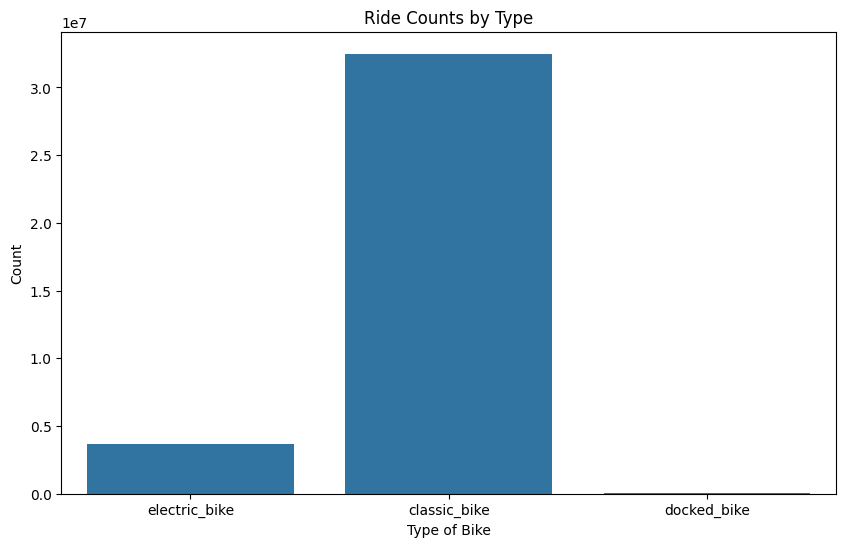

<Figure size 1000x600 with 0 Axes>

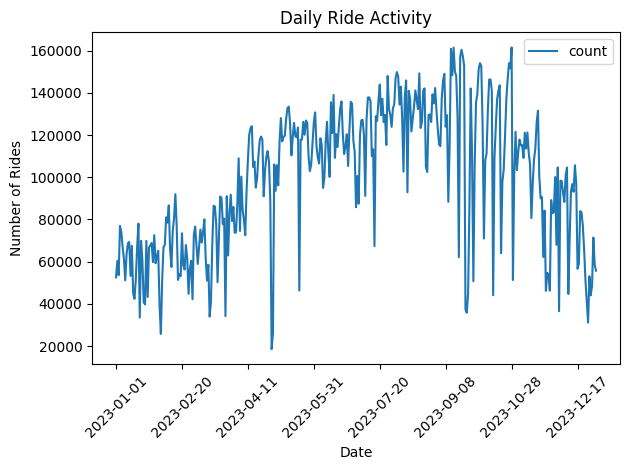

In [ ]:
ride_counts_pd = ride_counts.toPandas()
daily_rides_pd = daily_rides.toPandas()

# Plot Ride Counts by Type
plt.figure(figsize=(10, 6))
sns.barplot(data=ride_counts_pd, x='rideable_type', y='count')
plt.title('Ride Counts by Type')
plt.xlabel('Type of Bike')
plt.ylabel('Count')
plt.show()

# Plot Daily Rides
plt.figure(figsize=(10, 6))
daily_rides_pd.plot(x='date', y='count', kind='line')
plt.title('Daily Ride Activity')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

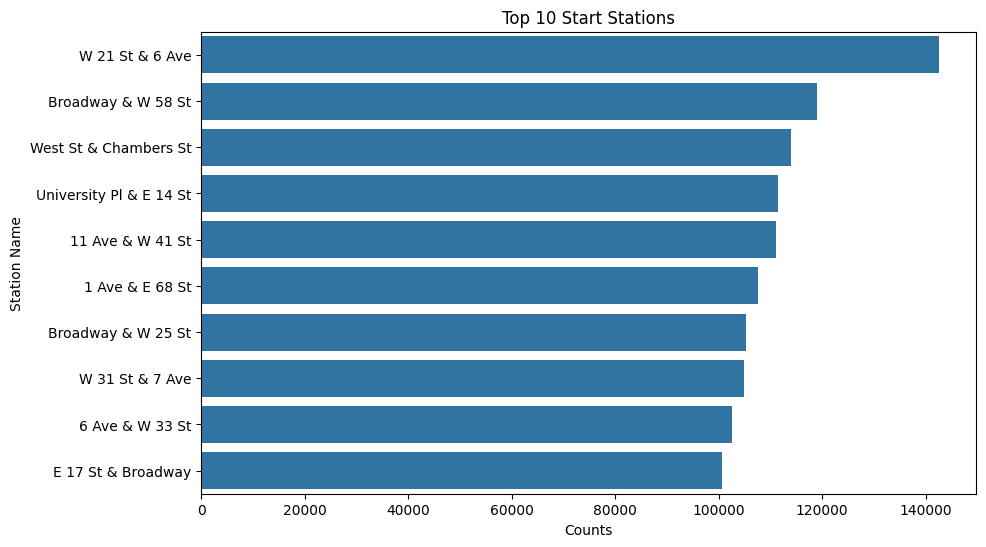

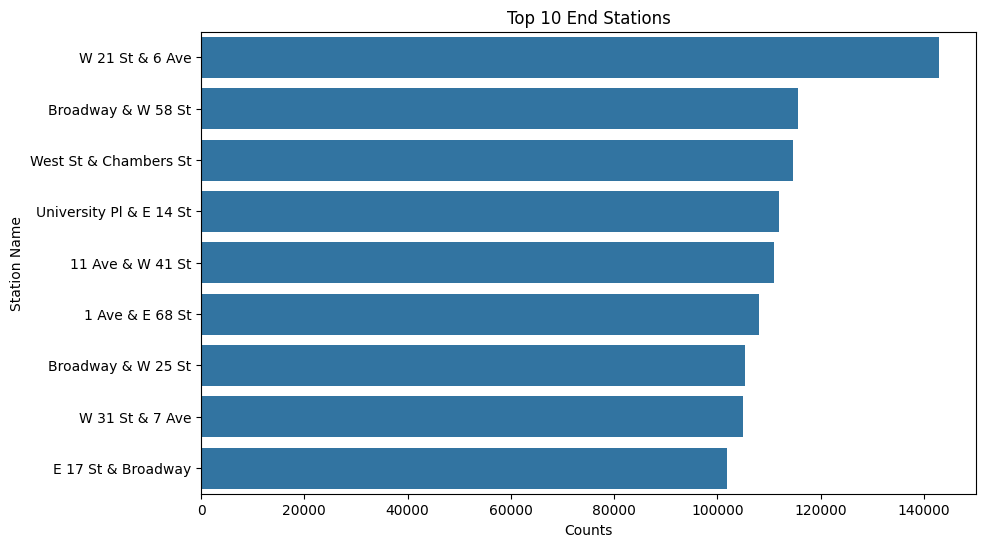

In [ ]:


# Most Popular Start and End Stations
top_start_stations = edf.groupBy("start_station_name").count().orderBy("count", ascending=False).limit(10)
top_end_stations = edf.groupBy("end_station_name").count().orderBy("count", ascending=False).limit(10)

top_start_stations_pd = top_start_stations.toPandas()
top_end_stations_pd = top_end_stations.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(y='start_station_name', x='count', data=top_start_stations_pd)
plt.title('Top 10 Start Stations')
plt.xlabel('Counts')
plt.ylabel('Station Name')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(y='end_station_name', x='count', data=top_end_stations_pd)
plt.title('Top 10 End Stations')
plt.xlabel('Counts')
plt.ylabel('Station Name')
plt.show()

+-----------+------------------+
|day_of_week|      avg_duration|
+-----------+------------------+
|          1| 17.26449813781312|
|          2|14.331965065582706|
|          3| 13.97108306611525|
|          4|13.810213190302312|
|          5|13.938310847299084|
|          6|14.521845221553765|
|          7|17.262338058289576|
+-----------+------------------+



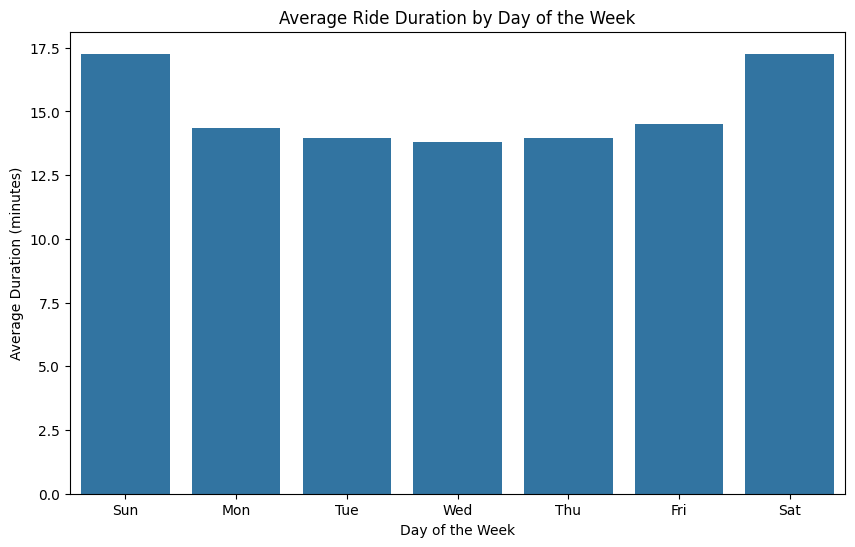

In [ ]:
from pyspark.sql.functions import dayofweek, avg

# Calculate average ride duration by day of the week
avg_duration_by_day = edf.withColumn("day_of_week", dayofweek("started_at")) \
    .groupBy("day_of_week") \
    .agg(avg("duration_minutes").alias("avg_duration")) \
    .orderBy("day_of_week")

avg_duration_by_day.show()

# Convert to Pandas DataFrame for plotting
avg_duration_by_day_pd = avg_duration_by_day.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='avg_duration', data=avg_duration_by_day_pd)
plt.title('Average Ride Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Duration (minutes)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

In [ ]:
# Group by membership type and date
member_rides_over_time = edf.withColumn("month", month("started_at")) \
    .groupBy("month", "member_casual") \
    .count()

member_rides_over_time.show()

# Convert to Pandas DataFrame for plotting
member_rides_over_time_pd = member_rides_over_time.toPandas()
member_rides_over_time_pd.pivot(index='month', columns='member_casual', values='count').plot(kind='bar', figsize=(12, 6))
plt.title('Rides by Membership Type Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

NameError: name 'month' is not defined

In [ ]:
# Convert 'started_at' and 'ended_at' to timestamp
df = df.withColumn("started_at", col("started_at").cast("timestamp"))
df = df.withColumn("ended_at", col("ended_at").cast("timestamp"))

# Extract day of week and hour from 'started_at' and 'ended_at'
df = df.withColumn("start_dayofweek", dayofweek("started_at"))
df = df.withColumn("start_hour", hour("started_at"))
df = df.withColumn("end_dayofweek", dayofweek("ended_at"))
df = df.withColumn("end_hour", hour("ended_at"))

In [ ]:
df.printSchema()

df.show()
df.count()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- start_dayofweek: integer (nullable = true)
 |-- start_hour: integer (nullable = true)
 |-- end_dayofweek: integer (nullable = true)
 |-- end_hour: integer (nullable = true)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------+-------------+-----------------+------------------+-------------+---------------+-------

36226600

In [ ]:
df_cleaned = df.na.drop(subset=["start_station_id"])
df_cleaned = df_cleaned.na.drop(subset=["end_station_id"])

In [ ]:
df_cleaned.count()

36117636

In [ ]:
df=df_cleaned

In [ ]:
from pyspark.sql import functions as F

# Count the starts and ends at each station for each hour and day
start_df = df.groupBy("start_station_id", "start_dayofweek", "start_hour")\
             .count()\
             .withColumnRenamed("count", "start_count")\
             .withColumnRenamed("start_station_id", "station_id")

end_df = df.groupBy("end_station_id", "end_dayofweek", "end_hour")\
           .count()\
           .withColumnRenamed("count", "end_count")\
           .withColumnRenamed("end_station_id", "station_id")

# Join starts and ends on station_id, dayofweek, and hour
feature_df = start_df.join(end_df,
                           (start_df.station_id == end_df.station_id) &
                           (start_df.start_dayofweek == end_df.end_dayofweek) &
                           (start_df.start_hour == end_df.end_hour),
                           "outer")\
                     .fillna(0)

# Calculate the differential
# Join starts and ends on station_id, dayofweek, and hour, and rename columns as needed
feature_df = start_df.join(
    end_df,
    (start_df.station_id == end_df.station_id) &
    (start_df.start_dayofweek == end_df.end_dayofweek) &
    (start_df.start_hour == end_df.end_hour),
    "outer"
).select(
    start_df.station_id,  # This ensures that the 'station_id' referenced post-join is unambiguous
    start_df.start_dayofweek.alias("dayofweek"),
    start_df.start_hour.alias("hour"),
    start_df.start_count,
    end_df.end_count
).fillna(0)

# Calculate the differential
feature_df = feature_df.withColumn("bike_availability_diff", feature_df.start_count - feature_df.end_count)

In [ ]:
def get_bike_availability_diff(feature_df, station_id, dayofweek, hour):
    # Filter the DataFrame for the given station_id, dayofweek, and hour
    result = feature_df.filter(
        (feature_df.station_id == station_id) &
        (feature_df.dayofweek == dayofweek) &
        (feature_df.hour == hour)
    ).select("station_id", "dayofweek", "hour", "bike_availability_diff")

    return result

# Example Usage
station_id = '5329.03'  # replace with actual station_id
dayofweek = 3  # replace with actual dayofweek (1=Monday, 7=Sunday)
hour = 15  # replace with actual hour (0-23)
result = get_bike_availability_diff(feature_df, station_id, dayofweek, hour)
result.show()

+----------+---------+----+----------------------+
|station_id|dayofweek|hour|bike_availability_diff|
+----------+---------+----+----------------------+
|   5329.03|        3|  15|                    84|
+----------+---------+----+----------------------+



In [ ]:
output_path = "/tmp/bike_diff"

# Coalesce the DataFrame to 1 partition (use cautiously)
feature_df.coalesce(1).write.option("header", "true").csv(output_path)

print(f"DataFrame coalesced and written to a single CSV at {output_path}")

DataFrame coalesced and written to a single CSV at /tmp/bike_diff


In [ ]:
start_df.show(10)

+----------+---------------+----------+-----------+
|station_id|start_dayofweek|start_hour|start_count|
+----------+---------------+----------+-----------+
|   6398.06|              1|        17|        257|
|   7327.01|              3|        17|        233|
|   6140.05|              7|        14|       1403|
|   4672.01|              5|         8|         82|
|   5300.06|              5|        15|         83|
|   5610.09|              3|        16|        610|
|   5065.14|              2|        17|        418|
|   5450.04|              4|        22|        347|
|   6089.08|              3|        21|        261|
|   4526.01|              7|         0|         71|
+----------+---------------+----------+-----------+
only showing top 10 rows



In [ ]:
end_df.show(10)

+----------+-------------+--------+---------+
|station_id|end_dayofweek|end_hour|end_count|
+----------+-------------+--------+---------+
|   7327.01|            3|      17|      222|
|   6115.06|            7|      14|      623|
|   5148.03|            7|      13|      204|
|   5148.03|            3|       1|       20|
|   6398.06|            4|      21|      164|
|   8403.02|            5|      22|       24|
|   6398.06|            1|      17|      246|
|   5066.03|            1|       3|       13|
|   7727.07|            6|      23|       23|
|   5170.01|            1|      17|       82|
+----------+-------------+--------+---------+
only showing top 10 rows



In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Index station_id if it's categorical
indexer = StringIndexer(inputCol="station_id", outputCol="station_id_indexed")

# Assemble features including the indexed station_id
assembler = VectorAssembler(inputCols=["station_id_indexed", "dayofweek", "hour"], outputCol="features")

# Define the model
rf = RandomForestRegressor(featuresCol="features", labelCol="bike_availability_diff", maxBins=2400)

# Create the pipeline with the indexer and assembler
pipeline = Pipeline(stages=[indexer, assembler, rf])

# Assuming feature_df_cleaned has been properly prepared and includes 'station_id'
train_data, test_data = feature_df_cleaned.randomSplit([0.8, 0.2])

# Train the model
model = pipeline.fit(train_data)

In [ ]:
indexer_model = indexer.fit(train_data)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions
predictions = model.transform(test_data)
#predictions
# Evaluate the model
#evaluator = RegressionEvaluator(labelCol="bike_availability_diff", predictionCol="prediction", metricName="rmse")
#rmse = evaluator.evaluate(predictions)
#print("Root Mean Squared Error (RMSE) on test data =", rmse)

DataFrame[station_id: string, dayofweek: int, hour: int, start_count: bigint, end_count: bigint, bike_availability_diff: bigint, station_id_indexed: double, features: vector, prediction: double]


In [ ]:
import pickle

# Create a file object for the model.
with open("/tmp/rf_model.pkl", "wb") as f:
    # Use the pickle.dump() function to serialize the model to the file.
    pickle.dump(model, f)

# Close the file.
f.close()

TypeError: cannot pickle '_thread.RLock' object

In [ ]:
model_path = "/content/drive/MyDrive/spark_rf_model"
model.write().overwrite().save(model_path)

In [ ]:
from pyspark.ml import PipelineModel

# Test data - ensuring we use the original labels as expected by the full pipeline
test_data = [("6140.05", 5, 1)]  # 'station_id' as a string, 'dayofweek', 'hour'

# Create a DataFrame with the correct initial column names
test_df = spark.createDataFrame(test_data, ["station_id", "dayofweek", "hour"])

# Load the complete PipelineModel which should include all transformations (indexing, vector assembling)
# and the regression model. Assuming it has been previously saved after full training.
model_path = "/tmp/spark_rf_model"
model = PipelineModel.load(model_path)

# Make predictions using the complete pipeline model on the test data
predictions = model.transform(test_df)

# Show predictions
predictions.select("features", "prediction").show()

+---------------+-------------------+
|       features|         prediction|
+---------------+-------------------+
|[417.0,5.0,1.0]|-28.985569167705854|
+---------------+-------------------+



In [ ]:
feature_df.printSchema()


root
 |-- station_id: string (nullable = true)
 |-- start_dayofweek: integer (nullable = true)
 |-- start_hour: integer (nullable = true)
 |-- start_count: long (nullable = true)
 |-- station_id: string (nullable = true)
 |-- end_dayofweek: integer (nullable = true)
 |-- end_hour: integer (nullable = true)
 |-- end_count: long (nullable = true)
 |-- bike_availability_diff: long (nullable = true)



ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
feature_df.tail(10)

[Row(station_id='SYS038', dayofweek=4, hour=23, start_count=1, end_count=14, bike_availability_diff=-13),
 Row(station_id='SYS038', dayofweek=5, hour=1, start_count=0, end_count=1, bike_availability_diff=-1),
 Row(station_id='SYS038', dayofweek=5, hour=2, start_count=0, end_count=2, bike_availability_diff=-2),
 Row(station_id='SYS038', dayofweek=5, hour=15, start_count=1, end_count=20, bike_availability_diff=-19),
 Row(station_id='SYS038', dayofweek=6, hour=3, start_count=0, end_count=3, bike_availability_diff=-3),
 Row(station_id='SYS038', dayofweek=6, hour=10, start_count=0, end_count=9, bike_availability_diff=-9),
 Row(station_id='SYS038', dayofweek=6, hour=20, start_count=0, end_count=10, bike_availability_diff=-10),
 Row(station_id='SYS038', dayofweek=6, hour=23, start_count=0, end_count=2, bike_availability_diff=-2),
 Row(station_id='SYS038', dayofweek=7, hour=2, start_count=0, end_count=2, bike_availability_diff=-2),
 Row(station_id='SYS039', dayofweek=5, hour=12, start_count=6,

In [ ]:
feature_df_cleaned = feature_df.na.drop(subset=["station_id"])

# Show the cleaned DataFrame to verify that rows with null 'station_id' have been removed
#feature_df_cleaned.count()

In [ ]:
feature_df.count()

367356

In [ ]:
from pyspark.sql.functions import col, when

# Assume start_df and end_df have been created correctly
# Now let's fix the join operation:

# First, ensure the columns are correctly named and match for the join
start_df = start_df.withColumnRenamed("start_station_id", "station_id")\
                   .withColumnRenamed("start_dayofweek", "dayofweek")\
                   .withColumnRenamed("start_hour", "hour")

end_df = end_df.withColumnRenamed("end_station_id", "station_id")\
               .withColumnRenamed("end_dayofweek", "dayofweek")\
               .withColumnRenamed("end_hour", "hour")

# Join starts and ends on station_id, dayofweek, and hour
feature_df = start_df.join(end_df, ["station_id", "dayofweek", "hour"], "outer").fillna(0)

# Compute the bike availability differential
feature_df = feature_df.withColumn("bike_availability_diff", feature_df.start_count - feature_df.end_count)

# Optionally, select and reorder columns to make it clearer
feature_df = feature_df.select("station_id", "dayofweek", "hour", "start_count", "end_count", "bike_availability_diff")

# Show the resulting DataFrame
feature_df.show()

+----------+---------+----+-----------+---------+----------------------+
|station_id|dayofweek|hour|start_count|end_count|bike_availability_diff|
+----------+---------+----+-----------+---------+----------------------+
|      NULL|        1|   0|         71|        0|                    71|
|      NULL|        1|   1|         66|        0|                    66|
|      NULL|        1|   2|         51|        0|                    51|
|      NULL|        1|   3|         38|        0|                    38|
|      NULL|        1|   7|         40|        0|                    40|
|      NULL|        1|   9|        105|        0|                   105|
|      NULL|        1|  20|         89|        0|                    89|
|      NULL|        1|  22|         46|        0|                    46|
|      NULL|        2|   2|         16|        0|                    16|
|      NULL|        2|   3|         13|        0|                    13|
|      NULL|        2|  14|        224|        0|  

In [ ]:
start_df.select("station_id").distinct().show()
end_df.select("station_id").distinct().show()

+----------+
|station_id|
+----------+
|   7790.04|
|   5902.07|
|   5922.08|
|   6248.06|
|    5470.1|
|   7722.06|
|   8049.05|
|   4677.06|
|   8198.05|
|   3394.03|
|   4157.10|
|   7541.01|
|   5128.04|
|   6306.01|
|   7738.04|
|   6471.02|
|   7940.02|
|   5570.04|
|   8458.03|
|   3526.06|
+----------+
only showing top 20 rows

+----------+
|station_id|
+----------+
|   7790.04|
|   7940.02|
|     HB103|
|   4374.01|
|     JC072|
|     HB301|
|   8123.02|
|   8122.04|
|   4648.03|
|   6151.03|
|   4735.16|
|   3811.05|
|   3736.04|
|   6131.12|
|   4293.05|
|   4903.09|
|   4019.06|
|   4862.04|
|   6058.08|
|   5021.05|
+----------+
only showing top 20 rows



In [ ]:
data = pd.read_csv('/tmp/aq/201306-citibike-tripdata.csv')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/JC-202403-citibike-tripdata.csv')

In [ ]:
print(data.shape)
data.head()

(65581, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9F5EEFB7CF78C6EA,electric_bike,2024-03-21 13:32:42,2024-03-21 13:35:42,Stevens - River Ter & 6 St,HB602,City Hall - Washington St & 1 St,HB105,40.743143,-74.026907,40.737360,-74.030970,member
1,01E2E1F218F9D303,electric_bike,2024-03-16 08:26:15,2024-03-16 08:47:53,Pershing Field,JC024,Pershing Field,JC024,40.742379,-74.051996,40.742677,-74.051789,member
2,C2914D662B33AA55,electric_bike,2024-03-15 15:17:36,2024-03-15 15:32:12,Pershing Field,JC024,Pershing Field,JC024,40.742480,-74.051942,40.742677,-74.051789,member
3,6723F7CE51888493,electric_bike,2024-03-13 08:34:26,2024-03-13 08:50:08,Pershing Field,JC024,Pershing Field,JC024,40.742400,-74.051963,40.742677,-74.051789,member
4,EAB7E29AAB546941,electric_bike,2024-03-15 15:37:58,2024-03-15 16:19:32,Pershing Field,JC024,Pershing Field,JC024,40.742459,-74.051973,40.742677,-74.051789,member


In [ ]:
%sh

base_url="https://s3.amazonaws.com/tripdata/"
ext=".csv.zip"
years=("2022" "2023")

for year in "${years[@]}"; do
  for month in {01..12};
   do
      if [ "$year" == "2022" ] && { [ "$month" == "06" ] || [ "$month" == "07" ]; }; then
        name_suffix="-citbike-tripdata"
      elif [ "$year" == "2023" ] && [ "$month" == "08" ]; then
        break  # Break out of the loop for July in 2023
      else
        name_suffix="-citibike-tripdata"
      fi

      file_name="{month}{ext}"
      url="{file_name}"
      output_path="/tmp/${file_name}"

      curl "$url" --output "$output_path"
      unzip -n "$output_path"
  done
done
echo -e "\e[1mDownloaded and unzipped Citibike data\e[0m"

SyntaxError: invalid syntax (<ipython-input-8-cebec9d35857>, line 7)